# Laboratory Final Project

- *Introduction to Statistical Computing*
- Author: Elena Conderana & Sergio Cuenca
- Date: XX/03/2025

---

## 1. Research questions
In this section, you should come up with research questions that can be answered with the
provided dataset. 

---

## 2. Data
In this section, sampling techniques shall be used on the data to obtain a sample of the
population from which we can draw conclusions on the whole dataset/US population. Here are
some ideas for questions that may be answered (you can add more):
- Describe the sampling method, which technique you have used and why.
- May the results of your EDA be generalized to the whole population from the sample you
have chosen?
- Discuss potential sources of bias based on the dataset description, how can these biases
affect your conclusions?

In [156]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy.stats as stats
import pandas as pd

In [157]:
df = pd.read_csv('brfss2013.csv', sep=",", encoding='cp1252', on_bad_lines='skip')

C:\Users\Elena\AppData\Local\Temp\ipykernel_9048\943110771.py:1: DtypeWarning: Columns (11,14,50,53,102,103,104,105,108,111,112,113,118,119,120,121,122,123,125,126,127,130,132,134,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,177,178,179,180,181,182,183,184,185,186,187,188,190,191,192,193,194,195,197,199,200,201,202,203,204,205,206,207,208,209,210,211,212,216,226,227,228,229,230,312) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('brfss2013.csv', sep=",", encoding='cp1252', on_bad_lines='skip')


In [158]:
df_hypothesis = pd.DataFrame()
df_hypothesis['heavyDrinking'] = df['X_rfdrhv4']
df_hypothesis['actLimitation'] = df['qlactlm2']
df_hypothesis['vet'] = df['veteran3'] 
df_hypothesis['healthCov'] = df['hlthpln1']
df_hypothesis['sex'] = df['sex']
df_hypothesis['avgDrinksDay'] = df['avedrnk2']
df_hypothesis['hopeless30'] = df['mishopls']
df_hypothesis['depressed30'] = df['misdeprd']
df_hypothesis['worthless30'] = df['miswtles']
df_hypothesis['employment'] = df['employ1']
df_hypothesis['kidneyDisease'] = df['chckidny']
df_hypothesis['maritalStatus'] = df['marital']
df_hypothesis['numberChildren'] = df['children']
df_hypothesis['lifeSatisfaction'] = df['lsatisfy']
df_hypothesis['stressMoneyRent12'] = df['scntmony']
df_hypothesis['emotionalSupport'] = df['emtsuprt']


In [159]:
na_counts = df_hypothesis.isna().sum()
print(na_counts)

heavyDrinking         23883
actLimitation         11329
vet                     746
healthCov              1904
sex                       7
avgDrinksDay         260590
hopeless30           484842
depressed30          486871
worthless30          487258
employment             3386
kidneyDisease          1721
maritalStatus          3420
numberChildren         2274
lifeSatisfaction     480104
stressMoneyRent12    429616
emotionalSupport     480154
dtype: int64


In [222]:
# Drop rows where 'vet' is NaN for sampling purposes
df_for_sampling = df.dropna(subset=['veteran3']).copy()

# Map 'veteran3' to numerical values for 'vet_flag'
df_for_sampling['vet_flag'] = df_for_sampling['veteran3'].map({'Yes': 1, 'No': 2}).astype(int)

# Calculate the proportions of veterans and non-veterans in the complete dataset
total_veterans = len(df_for_sampling[df_for_sampling['vet_flag'] == 1])
total_non_veterans = len(df_for_sampling[df_for_sampling['vet_flag'] == 2])
total_population = len(df_for_sampling)

proportion_veterans = total_veterans / total_population
proportion_non_veterans = total_non_veterans / total_population

# Define the total sample size
total_sample_size = int(0.1 * total_population)

# Calculate the sample sizes for each group based on the proportions
n_veterans = int(total_sample_size * proportion_veterans)
n_non_veterans = int(total_sample_size * proportion_non_veterans)

# Separate into strata
veterans = df_for_sampling[df_for_sampling['vet_flag'] == 1]
non_veterans = df_for_sampling[df_for_sampling['vet_flag'] == 2]

# Perform random sampling within each stratum
veteran_sample = veterans.sample(n=min(n_veterans, len(veterans)), random_state=42)
non_veteran_sample = non_veterans.sample(n=min(n_non_veterans, len(non_veterans)), random_state=42)

# Combine the samples
df_hypothesis_sampled = pd.concat([veteran_sample, non_veteran_sample])

# Now create your final df_hypothesis DataFrame with the sampled data
df_hypothesis = pd.DataFrame()
df_hypothesis['heavyDrinking'] = df_hypothesis_sampled['X_rfdrhv4']
df_hypothesis['actLimitation'] = df_hypothesis_sampled['qlactlm2']
df_hypothesis['vet'] = df_hypothesis_sampled['veteran3']
df_hypothesis['healthCov'] = df_hypothesis_sampled['hlthpln1']
df_hypothesis['sex'] = df_hypothesis_sampled['sex']
df_hypothesis['avgDrinksDay'] = df_hypothesis_sampled['avedrnk2']
df_hypothesis['hopeless30'] = df_hypothesis_sampled['mishopls']
df_hypothesis['depressed30'] = df_hypothesis_sampled['misdeprd']
df_hypothesis['worthless30'] = df_hypothesis_sampled['miswtles']
df_hypothesis['employment'] = df_hypothesis_sampled['employ1']
df_hypothesis['kidneyDisease'] = df_hypothesis_sampled['chckidny']
df_hypothesis['maritalStatus'] = df_hypothesis_sampled['marital']
df_hypothesis['numberChildren'] = df_hypothesis_sampled['children']
df_hypothesis['lifeSatisfaction'] = df_hypothesis_sampled['lsatisfy']
df_hypothesis['stressMoneyRent12'] = df_hypothesis_sampled['scntmony']
df_hypothesis['emotionalSupport'] = df_hypothesis_sampled['emtsuprt']
df_hypothesis['bingeDrinking'] = df_hypothesis_sampled['X_rfbing5']
# Convert 'vet' to a more descriptive categorical variable
df_hypothesis['vet_label'] = df_hypothesis['vet'].map({'Yes':1, 'No':0})

# Convert 'heavyDrinking' to a more descriptive categorical variable
df_hypothesis['heavyDrinking_label'] = df_hypothesis['heavyDrinking'].map({'No':0, 'Yes':1})

print(f"Sample size (veterans): {len(veteran_sample)}")
print(f"Sample size (non-veterans): {len(non_veteran_sample)}")
print(f"Total sample size: {len(df_hypothesis)}")

Sample size (veterans): 6144
Sample size (non-veterans): 42957
Total sample size: 49101


In [223]:
df_hypothesis

,heavyDrinking,actLimitation,vet,healthCov,sex,avgDrinksDay,hopeless30,depressed30,worthless30,employment,kidneyDisease,maritalStatus,numberChildren,lifeSatisfaction,stressMoneyRent12,emotionalSupport,bingeDrinking,vet_label,heavyDrinking_label
468454,No,No,Yes,Yes,Male,1.0,NaN,NaN,NaN,Retired,No,Widowed,0.0,NaN,NaN,NaN,No,1,0.0
297746,No,No,Yes,Yes,Male,NaN,NaN,NaN,NaN,Employed for wages,No,Married,0.0,NaN,NaN,NaN,No,1,0.0
94377,No,No,Yes,Yes,Male,1.0,NaN,NaN,NaN,Retired,No,Widowed,0.0,NaN,NaN,NaN,No,1,0.0
20359,No,No,Yes,Yes,Male,NaN,NaN,NaN,NaN,Retired,No,Married,0.0,NaN,Never,NaN,No,1,0.0
406247,No,Yes,Yes,Yes,Male,1.0,NaN,NaN,NaN,Retired,No,Married,0.0,NaN,NaN,NaN,No,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9331,No,No,No,Yes,Female,1.0,NaN,NaN,NaN,Employed for wages,No,Married,0.0,NaN,NaN,NaN,Yes,0,0.0
306706,No,No,No,Yes,Female,1.0,NaN,NaN,NaN,A homemaker,No,Married,0.0,NaN,NaN,NaN,No,0,0.0
429668,No,No,No,Yes,Female,NaN,NaN,NaN,NaN,Employed for wages,Yes,Married,3.0,NaN,NaN,NaN,No,0,0.0
67124,Yes,No,No,Yes,Female,4.0,NaN,NaN,NaN,Employed for wages,No,Divorced,0.0,NaN,NaN,NaN,Yes,0,1.0


---

## 3. EDA
In this section, perform an explorative analysis to answer the proposed questions in the previous
section. Justify the results and draw conclusions based on this analysis.

employ1: Employment Status
qlactlm2: Activity Limitation Due To Health Problems
marital: Marital Status


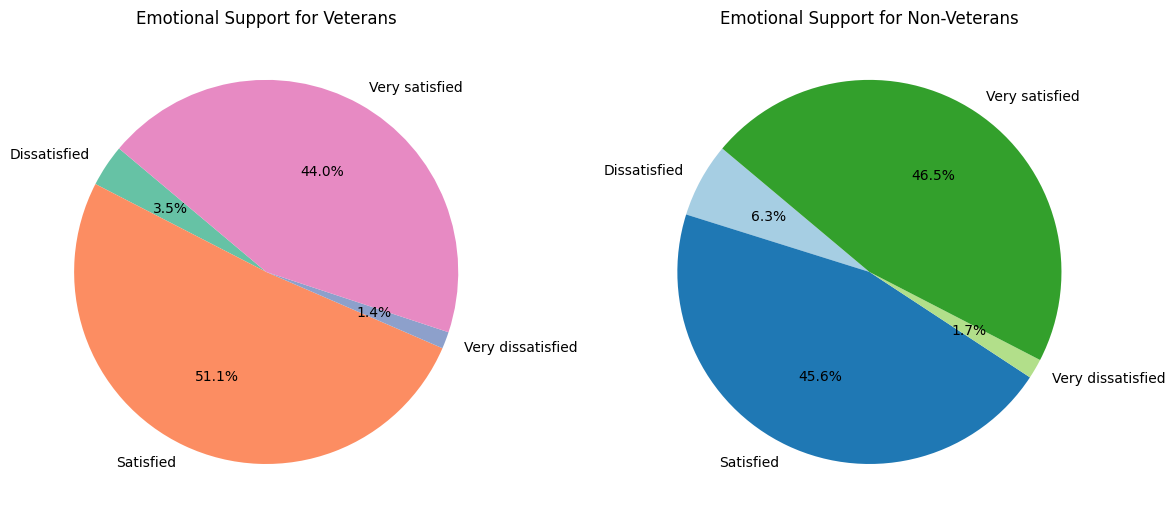

In [227]:
# Aggregate data for emotional support by veteran status
emotional_support_counts = df_hypothesis.groupby(['vet', 'lifeSatisfaction']).size().reset_index(name='Count')

# Separate data for veterans and non-veterans
veteran_support = emotional_support_counts[emotional_support_counts['vet'] == 'Yes']
non_veteran_support = emotional_support_counts[emotional_support_counts['vet'] == 'No']

# Plot pie chart for veterans
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.pie(veteran_support['Count'], labels=veteran_support['lifeSatisfaction'], autopct='%1.1f%%', startangle=140, colors=plt.cm.Set2.colors)
plt.title('Emotional Support for Veterans')

# Plot pie chart for non-veterans
plt.subplot(1, 2, 2)
plt.pie(non_veteran_support['Count'], labels=non_veteran_support['lifeSatisfaction'], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Emotional Support for Non-Veterans')

plt.tight_layout()
plt.show()

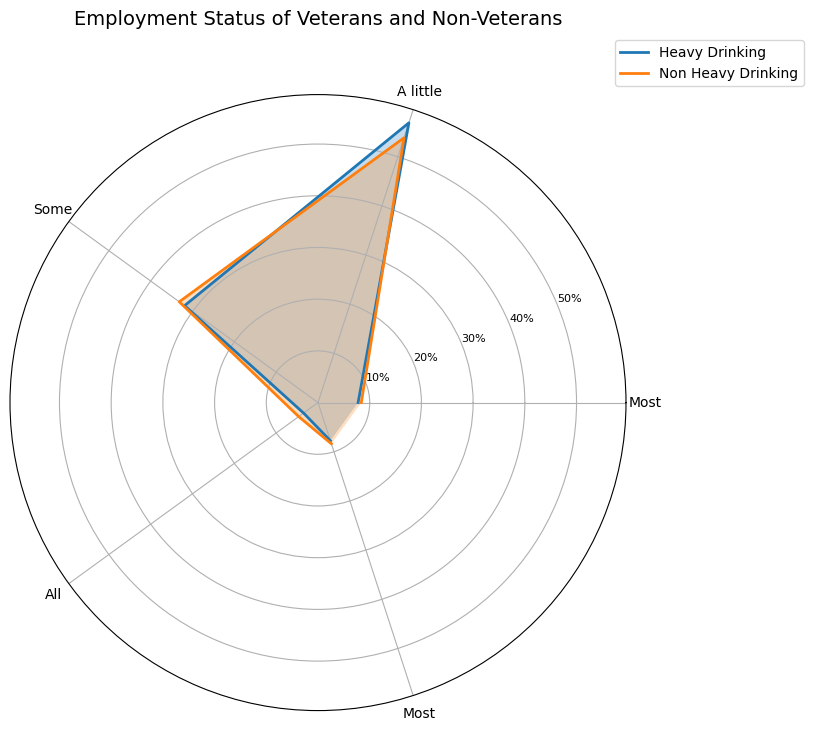

: 

In [ ]:
from math import pi

# Prepare data for radar chart
employment_status = df_hypothesis['hopeless30'].unique()
employment_status = [status for status in employment_status if pd.notna(status)]  # Remove NaN values

# Calculate proportions for each employment status
veteran_employment = df_hypothesis[df_hypothesis['bingeDrinking'] == 'Yes']['hopeless30'].value_counts(normalize=True)
non_veteran_employment = df_hypothesis[df_hypothesis['bingeDrinking'] == 'No']['hopeless30'].value_counts(normalize=True)

# Ensure all employment statuses are included
veteran_values = [veteran_employment.get(status, 0) for status in employment_status]
non_veteran_values = [non_veteran_employment.get(status, 0) for status in employment_status]

# Add the first value to close the radar chart
veteran_values += veteran_values[:1]
non_veteran_values += non_veteran_values[:1]
employment_status += [employment_status[0]]

# Create radar chart
angles = [n / float(len(employment_status)) * 2 * pi for n in range(len(employment_status))]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot data
ax.plot(angles[:-1], veteran_values, linewidth=2, linestyle='solid', label='Heavy Drinking')
ax.fill(angles[:-1], veteran_values, alpha=0.25)

ax.plot(angles[:-1], non_veteran_values, linewidth=2, linestyle='solid', label='Non Heavy Drinking')
ax.fill(angles[:-1], non_veteran_values, alpha=0.25)

# Add labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(employment_status, fontsize=10)
ax.set_yticks([0.1, 0.2, 0.3, 0.4, 0.5])
ax.set_yticklabels(['10%', '20%', '30%', '40%', '50%'], fontsize=8)
ax.set_title('Employment Status of Veterans and Non-Veterans', size=14, y=1.1)

# Add legend
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.show()

In [ ]:
# Calculate proportions of activity limitations by veteran status
act_limitation_proportions = df_hypothesis.groupby('vet')['actLimitation'].value_counts(normalize=True).unstack()

# Display the proportions
print(act_limitation_proportions)

actLimitation        No       Yes
vet                              
No             0.764115  0.235885
Yes            0.696238  0.303762


C:\Users\Elena\AppData\Local\Temp\ipykernel_9048\2951302514.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_hypothesis.dropna(subset=['avgDrinksDay', 'vet']), x='vet', y='avgDrinksDay', palette=['#90EE90', '#ADD8E6'], ax=axs[2], legend=True) #changed palette


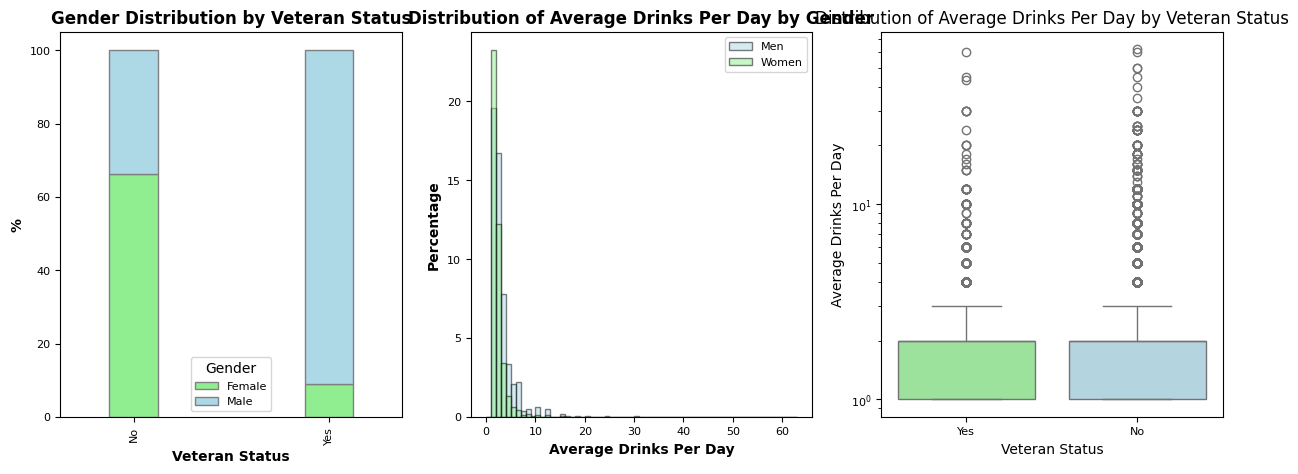

In [214]:
# Define bar width
barWidth = 0.25
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Adjusted for side-by-side, and reduced height

# First Chart: Gender Distribution by Veteran Status
# Group data by 'vet' and 'sex' and calculate percentages
grouped_data = df_hypothesis.groupby(['vet', 'sex']).size().unstack()
grouped_data_percentage = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100

# Plot bars for each gender
grouped_data_percentage.plot(kind='bar', stacked=True, width=barWidth, ax=axs[0], color=['#90EE90', '#ADD8E6'], edgecolor='grey')

# Set labels and title
axs[0].set_xlabel('Veteran Status', fontweight='bold', fontsize=10)
axs[0].set_ylabel('%', fontweight='bold', fontsize=10)
axs[0].set_title('Gender Distribution by Veteran Status', fontweight='bold', fontsize=12)
axs[0].tick_params(axis='both', labelsize=8)

# Add legend
axs[0].legend(title='Gender', labels=['Female', 'Male'], fontsize=8)


# Second Chart: Distribution of Average Drinks Per Day by Gender
# Filter data by gender
male_data = df_hypothesis[df_hypothesis['sex'] == 'Male']['avgDrinksDay']
female_data = df_hypothesis[df_hypothesis['sex'] == 'Female']['avgDrinksDay']

# Determine the maximum value for consistent bin edges
max_val = df_hypothesis['avgDrinksDay'].max()
bins = range(int(max_val) + 2)  # Ensure bins go beyond the max value, +2 to include the top value.

# Plot histograms with logarithmic scale and consistent bins
n_male, bins_male, patches_male = axs[1].hist(male_data, bins=bins, alpha=0.5, label='Men', color='#ADD8E6', edgecolor='black', log=True)
n_female, bins_female, patches_female = axs[1].hist(female_data, bins=bins, alpha=0.5, label='Women', color='#90EE90', edgecolor='black', log=True)

# Calculate percentages
total_male = len(male_data)
total_female = len(female_data)
percentage_male = [x / total_male * 100 for x in n_male]
percentage_female = [x / total_female * 100 for x in n_female]

# Clear the current axes and plot the percentages
axs[1].cla()
axs[1].bar(bins_male[:-1], percentage_male, width=1, align='edge', alpha=0.5, label='Men', color='#ADD8E6', edgecolor='black')
axs[1].bar(bins_female[:-1], percentage_female, width=1, align='edge', alpha=0.5, label='Women', color='#90EE90', edgecolor='black')


# Add labels, title, and legend
axs[1].set_xlabel('Average Drinks Per Day', fontweight='bold', fontsize=10)
axs[1].set_ylabel('Percentage', fontweight='bold', fontsize=10) # Changed Y label to percentage
axs[1].set_title('Distribution of Average Drinks Per Day by Gender', fontweight='bold', fontsize=12)
axs[1].legend(fontsize=8)
axs[1].tick_params(axis='both', labelsize=8)

# Third Chart: Average Drinks Per Day by Heavy Drinking Status
# Use the same colors as the bar chart for the boxplot
sns.boxplot(data=df_hypothesis.dropna(subset=['avgDrinksDay', 'vet']), x='vet', y='avgDrinksDay', palette=['#90EE90', '#ADD8E6'], ax=axs[2], legend=True) #changed palette
axs[2].set_title('Distribution of Average Drinks Per Day by Veteran Status', fontsize=12)
axs[2].set_xlabel('Veteran Status', fontsize=10)
axs[2].set_ylabel('Average Drinks Per Day', fontsize=10)
axs[2].set_yscale('log')
axs[2].tick_params(axis='both', labelsize=8)


Display proportion of population that cannot drink (pregnant, under age,...)

---

## 4. Inference statistics
In this section, perform a statistical analysis on the data to respond to the research questions
proposed in section 1. You have to answer at least one question via confidence interval and at
least one question via hypothesis testing. Alternatively, you can answer one of the questions
using a Bayesian model. 

## Inference for two proportions

In [225]:
# Sample data
sample_size_vet = len(df_hypothesis[df_hypothesis['vet'] == 'Yes'])
sample_size_non_vet = len(df_hypothesis[df_hypothesis['vet'] == 'No'])
sample_count_vet_heavy = len(df_hypothesis[(df_hypothesis['vet'] == 'Yes') & (df_hypothesis['bingeDrinking'] == 'Yes')])
sample_count_non_vet_heavy = len(df_hypothesis[(df_hypothesis['vet'] == 'No') & (df_hypothesis['bingeDrinking'] == 'Yes')])

# Sample proportions
sample_p_vet = sample_count_vet_heavy/sample_size_vet
sample_p_non_vet = sample_count_non_vet_heavy/sample_size_non_vet

# Pooled proportion
p_pooled = (sample_count_vet_heavy + sample_count_non_vet_heavy)/(sample_size_vet + sample_size_non_vet)

# Standard error
sample_std = np.sqrt(p_pooled * (1 - p_pooled) * (1 / sample_size_vet + 1 / sample_size_non_vet))

# Z-score
z_score = (sample_p_vet - sample_p_non_vet) / sample_std

# Test type
test_type = 'two-sided' # 'one-sided'

# Calculate p-value
if test_type == 'two-sided':
    p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))  # Two-tailed test
elif test_type == 'one-sided':
    p_value = (1 - stats.norm.cdf(abs(z_score))) # One-tailed test

# Significance level
alpha = 0.05

# Results
print("Z-score:", z_score)
print("P-value:", p_value)

if p_value < alpha:
    print("Reject the null hypothesis. The proportions are significantly different.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference between the proportions.")

Z-score: -2.417914433240362
P-value: 0.01560974701843132
Reject the null hypothesis. The proportions are significantly different.
